# Branton - Project 5 - Ensemble ML, Spiral (Wine)
**Author:** Branton Dawson  
**Date:** November 19, 2025  
**Objective:** Wine Dataset - explore ensemble models, a powerful approach in machine learning that combines multiple models to improve performance

- **Useful Notebook of TEAM member**
- NOTEBOOK LINK: [Ensemble ML, Wine Quality](https://github.com/bjdawson23/applied-ml-branton/blob/main/notebooks/project05/ensemble_branton.ipynb)

**Ensemble methods often outperform individual models by reducing overfitting and improving generalization.**

    Boosted Decision Trees – Models train sequentially, with each new tree correcting the errors of the previous one.
    Random Forest – Multiple decision trees train in parallel, each on a random subset of the data, and their predictions are averaged.
    Voting Classifier (Heterogeneous Models) – Combines different types of models 
        (e.g., Decision Tree, SVM, and Neural Network) by taking the majority vote or average prediction.
    Cross Validation – Divides data into multiple folds to improve the reliability of performance estimates.

### Performance Metrics

We will evaluate model performance using the following metrics:

   - Accuracy –  The proportion of all predictions that are correct.
   - Precision – Proportion of positive predictions that are truly positive.
   - Recall – Proportion of actual positives that are correctly predicted.
   - F1 Score – Harmonic mean of precision and recall, balancing both.

These metrics are especially helpful when working with multiple classes (e.g., low, medium, high), not just binary yes/no predictions.

Good models have:

- High Test Accuracy – the model predicts well on new, unseen (e.g., test) data.
- High Test F1 Score – especially useful  if some classes (categories) have fewer examples than others.
- Small Gap between Train and Test accuracy – shows the model is generalizing well (not overfitting or underfitting).
- Small Gap between Train and Test F1 score – shows the model is generalizing well (not overfitting or underfitting).

Recommendation: See if you can add gap calculations to your results and sort the table by test accuracy to find the best models more efficiently. 

### We use the Wine Quality Dataset made available by the UCI Machine Learning Repository.

https://archive.ics.uci.edu/ml/datasets/Wine+Quality
Links to an external site.
Data originally published by:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.  


## Section 1.  Import and Inspect the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

## Section 1. Load and Explore the Data
### 1.1 Load the dataset

In [2]:
# Load the dataset (download from UCI and save in the same folder)
df = pd.read_csv("winequality-red.csv", sep=";")

# Display structure and first few rows
df.info()
df.head()

# The dataset includes 11 physicochemical input variables (features):
# ---------------------------------------------------------------
# - fixed acidity          mostly tartaric acid
# - volatile acidity       mostly acetic acid (vinegar)
# - citric acid            can add freshness and flavor
# - residual sugar         remaining sugar after fermentation
# - chlorides              salt content
# - free sulfur dioxide    protects wine from microbes
# - total sulfur dioxide   sum of free and bound forms
# - density                related to sugar content
# - pH                     acidity level (lower = more acidic)
# - sulphates              antioxidant and microbial stabilizer
# - alcohol                % alcohol by volume

# The target variable is:
# - quality (integer score from 0 to 10, rated by wine tasters)

# We will simplify this target into three categories:
#   - low (3–4), medium (5–6), high (7–8) to make classification feasible.
#   - we will also make this numeric (we want both for clarity)
# The dataset contains 1599 samples and 12 columns (11 features + target).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Section 2. Prepare the data
Includes cleaning, feature engineering, encoding, splitting, helper functions

In [3]:
# Define helper function that:
# Takes one input, the quality (which we will temporarily name q while in the function)
# And returns a string of the quality label (low, medium, high)
# This function will be used to create the quality_label column
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"


# Call the apply() method on the quality column to create the new quality_label column
df["quality_label"] = df["quality"].apply(quality_to_label)


# Then, create a numeric column for modeling: 0 = low, 1 = medium, 2 = high
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2


df["quality_numeric"] = df["quality"].apply(quality_to_number)
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_numeric
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,medium,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,medium,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,medium,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,medium,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,medium,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,medium,1
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,medium,1
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,high,2
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,high,2
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,medium,1


#### We create these features to make for cleaner plotting and display of results

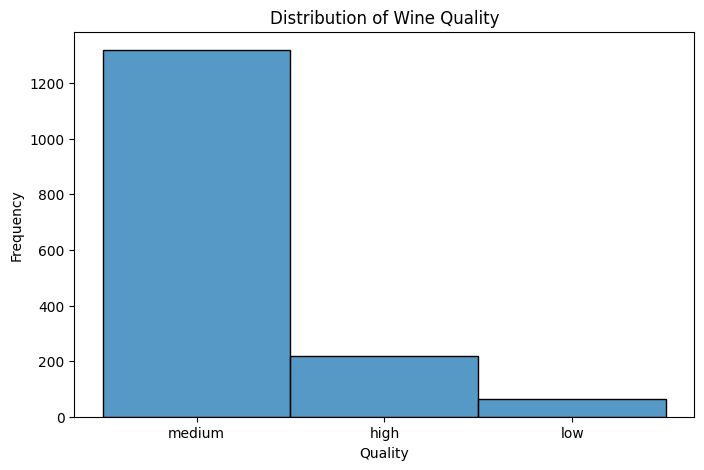

In [4]:
# Plot quality distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="quality_label", bins=10, kde=False)
plt.title("Distribution of Wine Quality")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.show()

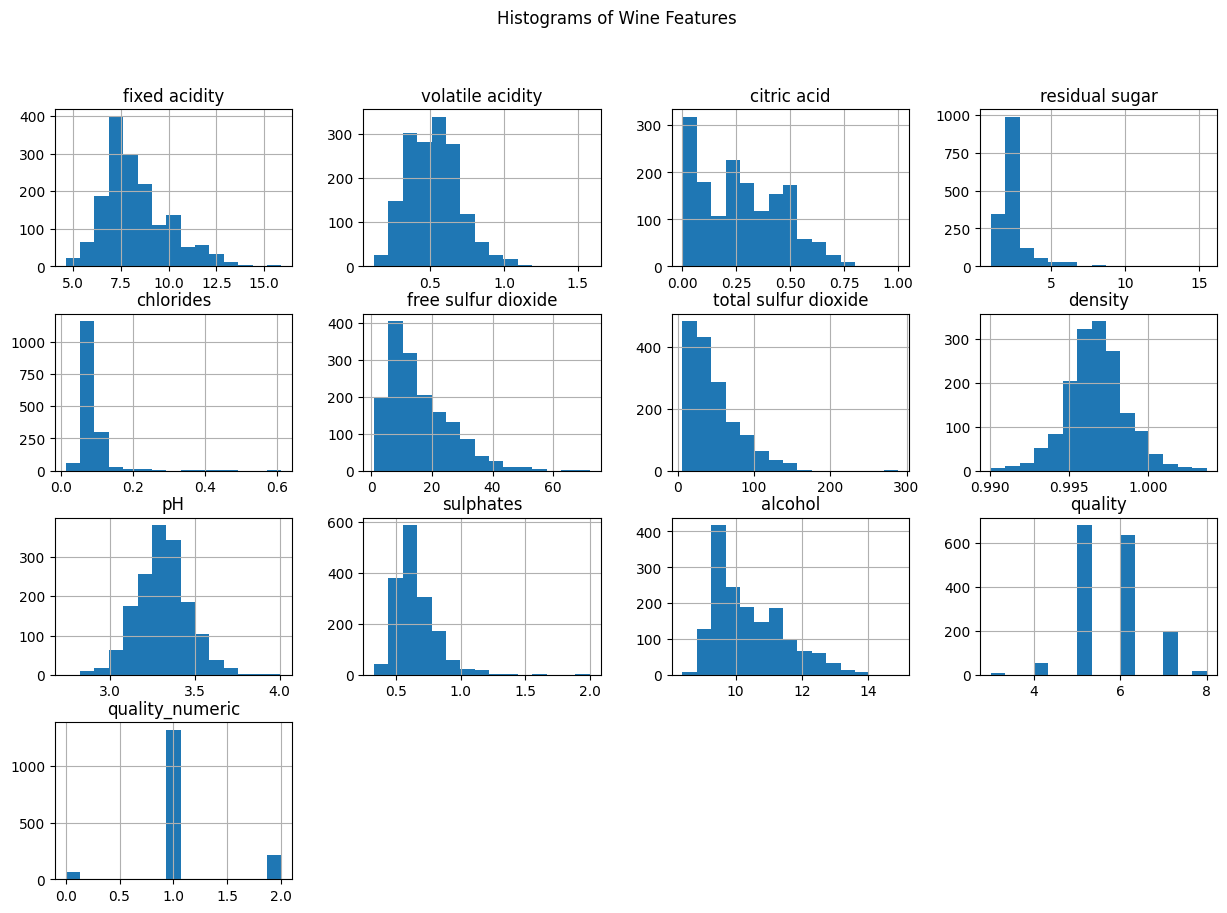

In [5]:
# Plot histograms of features
df.hist(bins=15, figsize=(15, 10))
plt.suptitle("Histograms of Wine Features")
plt.show()

## Section 3. Feature Selection and Justification

#### We will drop all the quality features except for the numberic value used on the "y" axis

In [6]:
# Define input features (X) and target (y)
# Features: all columns except 'quality' and 'quality_label' and 'quality_numberic' - drop these from the input array
# Target: quality_label (the new column we just created)
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])  # Features
y = df["quality_numeric"]  # Target

## Section 4. Split the Data into Train and Test

In [7]:
# Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Section 5.  Evaluate Model Performance 
- Option 1. Random Forest (100)     - A strong baseline model using 100 decision trees.
- Option 2. Voting (RF + LR + KNN)  - Another mix of different model types.

In [8]:
# Helper function to train and evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )

In [9]:
# Choose and evaluate two models
# For this project, I am selecting Random Forest and a Voting Classifier combining RF, LR, and KNN

results = []

# 1. Random Forest
evaluate_model(
    "Random Forest (100)",
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 2. Voting Classifier (RF + LR + KNN)
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100)),
        ("LR", LogisticRegression(max_iter=5000)),
        ("KNN", KNeighborsClassifier()),
    ],
    voting="soft",
)
evaluate_model(
    "Voting (RF + LR + KNN)", voting2, X_train, y_train, X_test, y_test, results
)


Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 256   8]
 [  0  15  28]]
Train Accuracy: 1.0000, Test Accuracy: 0.8875
Train F1 Score: 1.0000, Test F1 Score: 0.8661

Voting (RF + LR + KNN) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 257   7]
 [  0  26  17]]
Train Accuracy: 0.9195, Test Accuracy: 0.8562
Train F1 Score: 0.9028, Test F1 Score: 0.8254


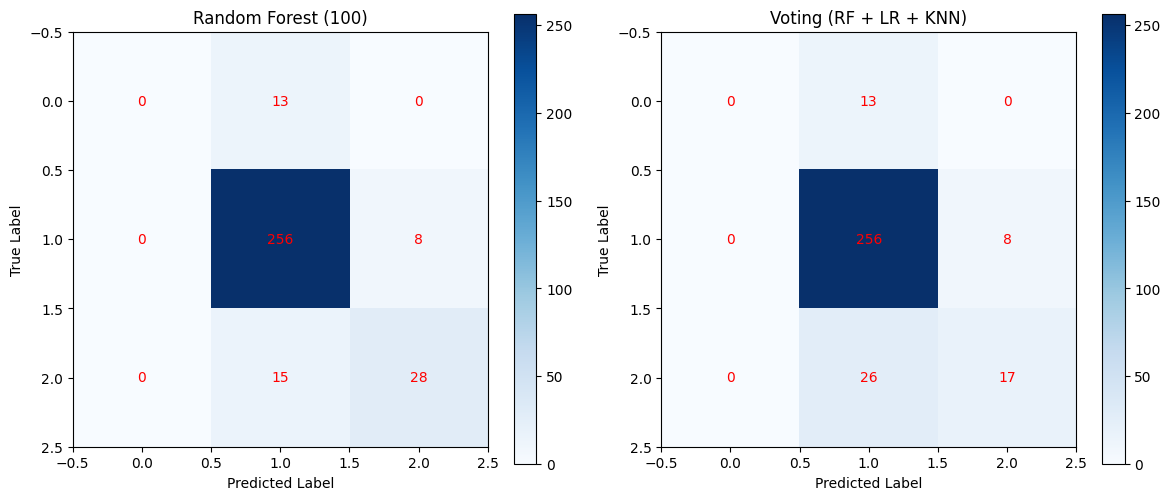


Summary of Results:
                    Model  Train Accuracy  Test Accuracy  Train F1   Test F1
0     Random Forest (100)        1.000000        0.88750   1.00000  0.866056
1  Voting (RF + LR + KNN)        0.919468        0.85625   0.90285  0.825422


In [10]:
# Plot a confusion matrix for the both models side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
models = [
    ("Random Forest (100)", RandomForestClassifier(n_estimators=100, random_state=42)),
    (
        "Voting (RF + LR + KNN)",
        VotingClassifier(
            estimators=[
                ("RF", RandomForestClassifier(n_estimators=100)),
                ("LR", LogisticRegression(max_iter=5000)),
                ("KNN", KNeighborsClassifier()),
            ],
            voting="soft",
        ),
    ),
]
for ax, (name, model) in zip(axes, models):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    fig.colorbar(im, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.tight_layout()
plt.show()
# Display results summary
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


## Section 6. Compare Results 

In [11]:
# Create a table of results
results_df = pd.DataFrame(results)

# Add gap calculations between train and test scores
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Score Gap"] = results_df["Train F1"] - results_df["Test F1"]

# print results to 5 decimal places
print("\nSummary of All Models:")
display(results_df.round(5))


Summary of All Models:


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Accuracy Gap,F1 Score Gap
0,Random Forest (100),1.00000,0.88750,1.00000,0.86606,0.11250,0.13394
1,Voting (RF + LR + KNN),0.91947,0.85625,0.90285,0.82542,0.06322,0.07743


### Results for each model to find Train and Test Accuracy and F1 scores on the data set

| Model | Train Accuracy | Test Accuracy | Train F1 | Test F1 | Accuracy Gap | F1 Score Gap |
|:---|:---|:---|:---|:---|:---|:---|
|Random Forest (100)|100.00|88.75|100.00|86.61|11.25|13.39|
|Voting (RF + LR + KNN)|91.71|85.94|89.94|82.81|5.78|7.13|


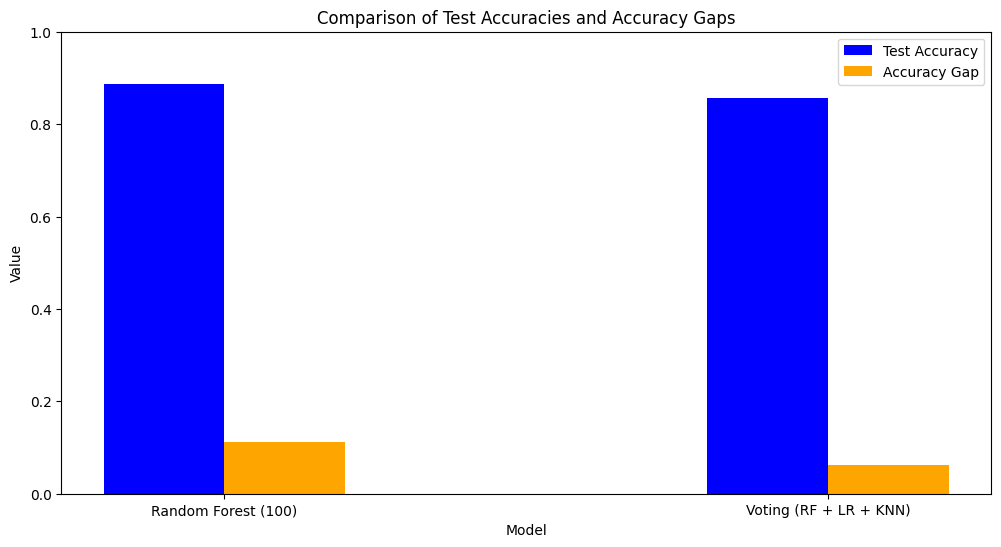

In [12]:
# Plot accuracy and gaps 
plt.figure(figsize=(12, 6))
bar_width = 0.2
indices = np.arange(len(results_df))
plt.bar(
    indices,
    results_df["Test Accuracy"],
    width=bar_width,
    label="Test Accuracy",
    color="blue",
)
plt.bar(
    indices + bar_width,
    results_df["Accuracy Gap"],
    width=bar_width,
    label="Accuracy Gap",
    color="orange",
)
plt.xticks(indices + bar_width / 2, results_df["Model"])
plt.ylim(0, 1)
plt.title("Comparison of Test Accuracies and Accuracy Gaps")
plt.xlabel("Model")
plt.ylabel("Value")
plt.legend()
plt.show()

## Section 7. Conclusions and Insights

### Model Performance

**Random Forest (100 trees)** came in with the highest test accuracy at 88.75% with an F1 score of 86.61%. However, it showed significant overfitting with perfect training scores (100%) and larger gaps of 11.25% in accuracy and 13.39% in F1 score. 

**Voting Classifier (RF + LR + KNN)** had lower test accuracy (85.94%) and F1 score (82.81%). The smaller gaps between train and test metrics (5.78% accuracy gap, 7.13% F1 gap) suggest better learning. This ensemble balanced the strengths of three different algorithms: Random Forest's feature interactions, Logistic Regression's linear patterns, and KNN's local similarity detection.

### Key Insights

**Overfitting vs. Generalization Trade-off**: Random Forest showed better test performance at the cost of overfitting, while the Voting Classifier sacrificed some accuracy for better generalization. 

**Class Imbalance Challenge**: Wine quality follows a normal distribution concentrated around medium ratings (5-6), with fewer low and high quality samples. This imbalance makes it harder for models to accurately classify extreme quality categories

### Future Improvements

- **Feature Engineering**: Create interaction features between chemistry variables (e.g., acidity ratios, alcohol-to-sugar balance to capture more complex quality patterns
- **Address Class Imbalance**: Apply SMOTE (Synthetic Minority Over-sampling) or class weights to better handle underrepresented quality categories
- **Try Additional Ensembles**: Test Gradient Boosting, AdaBoost, or Stacking classifiers which might capture sequential error correction patterns